# Illustrations for the Baseline Model

In [41]:
# import relevant packages 
from scipy.signal import find_peaks
from matplotlib import pyplot as plt 
import seaborn as sns 
import numpy as np 
import pickle 
import pywt 

sns.set_theme()

rcParams = {
    "font.family": "serif",  # use serif/main font for text elements
    'text.usetex': True,
    'font.size': 8,
    'axes.labelsize': 7,
    'axes.titlesize': 9,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 7,
    'axes.labelpad': 1,
    'axes.axisbelow': True,  # draw gridlines below other elements
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.preamble": "\n".join([
        r"\usepackage{url}",            # load additional packages
        r"\usepackage{amsmath,amssymb}",   # unicode math setup
        #  r"\setmainfont{DejaVu Serif}",  # serif font via preamble
    ])
}
plt.rcParams.update(rcParams)

figdir = "../../../figures/methods/"
def savefig(fig, name, width=6, height=4):
    # apply rcParams
    fig.set_size_inches(width, height)
    fig.savefig(figdir + name + ".pdf", bbox_inches='tight')

def bin_data(channel, peaks):
    """
    Bin data into 80ms bins
    """
    binned_data = np.zeros((100, 2400))
    for c, peak in enumerate(peaks):
        if c == 100: break 
        if (c == 99) & (peak+2700 > len(channel)):
            binned_data[c, :len(channel) - peak] = channel[peak:]
        else: 
            binned_data[c] = channel[peak+300:peak+2700]
    
    return binned_data

def get_accepted_coefficients(coefficients : np.ndarray, scales : np.ndarray) -> np.ndarray:
    accepted_coefficients = np.zeros_like(coefficients)

    # loop over scales 
    for j in range(len(scales)): 
        # extract current coefficients
        x = coefficients[j]

        # estimate noise level 
        sigma_j = np.median(np.abs(x - np.mean(x))) / 0.6745 

        # compute hard threshold 
        T = np.sqrt(2 * np.log(len(x))) * sigma_j

        # find indices of coefficients that exceed threshold
        index = np.where(np.abs(x) > T)[0]

        if len(index) > 0: 
            # compute sample mean 
            mu = np.mean(np.abs(x[index]))

            # compute probabilities
            p_spikes = len(index) / len(x)
            p_noise = 1 - p_spikes

            # compute gamma
            log_gamma = 36.7368 * (0) + np.log(p_noise / p_spikes)

            # compute acceptance threshold
            theta = mu / 2 + sigma_j**2 / mu * log_gamma

            # apply acceptance threshold
            accepted_coefficients[j] = x * (np.abs(x) > theta)

    return accepted_coefficients

### Mother wavelet 

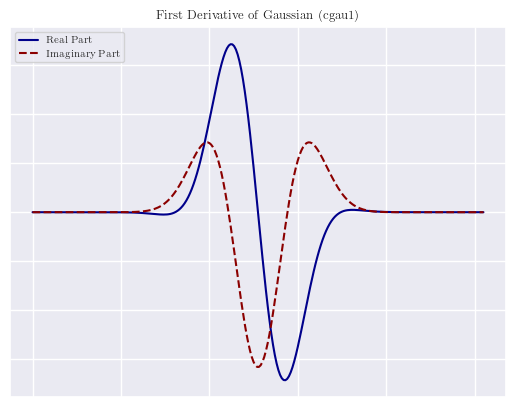

In [20]:
wavelet = pywt.ContinuousWavelet('cgau1')

fig, ax = plt.subplots(1, 1)
ax.plot(np.real(wavelet.wavefun()[0]), color = "darkblue", label = "Real Part")
ax.plot(np.imag(wavelet.wavefun()[0]), color = "darkred", linestyle = "--", label = "Imaginary Part")
ax.set_title("First Derivative of Gaussian (cgau1)")
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.legend(loc = "upper left")
plt.show()

savefig(fig, "cgau1_wavelet", width = 4, height = 2.5)

### Wavelet Coefficients 

In [43]:
with open("simulated_data.pkl", 'rb') as f:
    file = pickle.load(f)
f.close()

channel = 2
bin_idx = 1
peaks, _ = find_peaks(file['filtered_signal'][:, channel], height = 30, distance = 2900)
bins = bin_data(file['filtered_signal'][:, channel], peaks).T 
true_bins = bin_data(file['true_signal'][:, channel], peaks).T

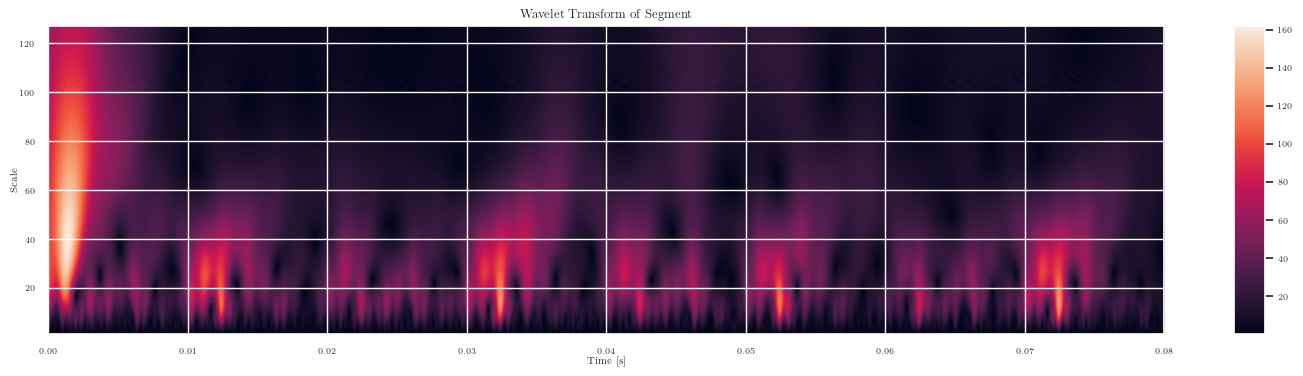

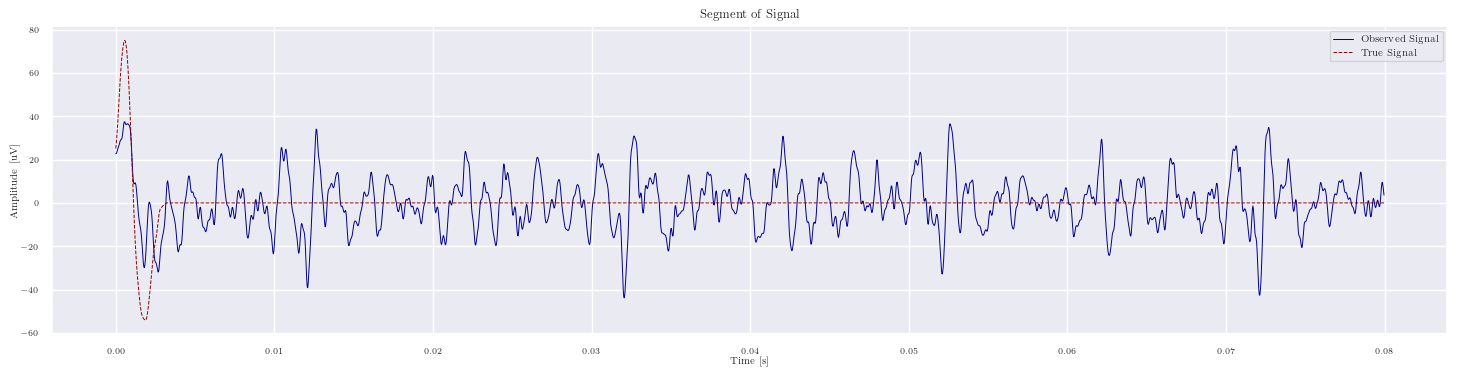

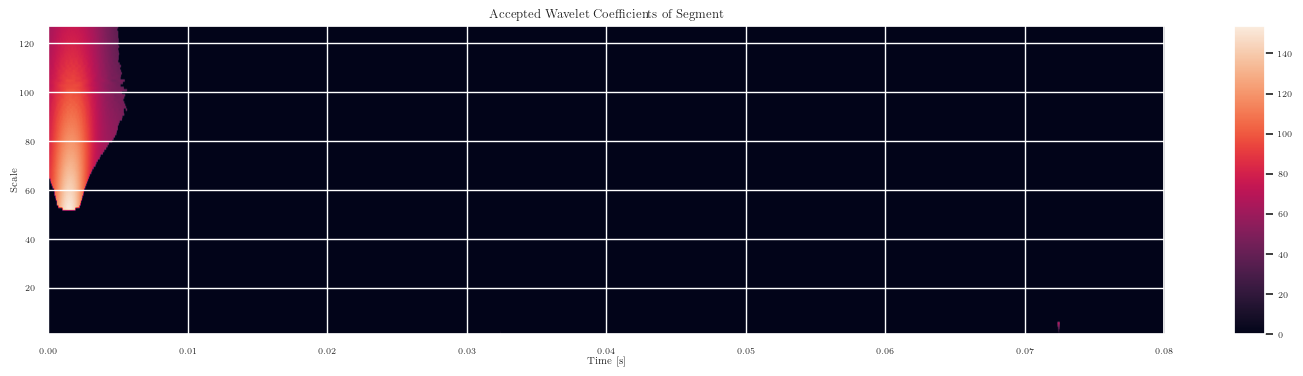

In [72]:
# apply wavelet transform
scales = np.arange(1, 128)
coefficients, frequencies = pywt.cwt(bins[:, bin_idx], scales=scales, wavelet='cgau1', sampling_period=1/30000)

fig = plt.figure(figsize = (18, 4))
plt.imshow(np.abs(coefficients), extent=[0, len(bins) / 30000, scales.min(), scales.max()],
           aspect='auto', origin='lower')
plt.colorbar(aspect=10)
plt.title("Wavelet Transform of Segment")
plt.ylabel("Scale")
plt.xlabel("Time [s]")
plt.show()

savefig(fig, "wavelet_coefficients", width = 6, height=1.5)

fig = plt.figure(figsize = (18, 4))
plt.plot(np.arange(2400) / 30000, bins[:, bin_idx], color = "darkblue", linewidth = 0.7)
plt.plot(np.arange(2400) / 30000, true_bins[:, bin_idx], '--', color = "darkred", linewidth = 0.7)
plt.title("Segment of Signal")
plt.ylabel("Amplitude [uV]")
plt.xlabel("Time [s]")
plt.legend(["Observed Signal", "True Signal"])
plt.show()

savefig(fig, "wavelet_time_segment", width = 6, height=1.5)

accepted_coefficients = get_accepted_coefficients(coefficients, scales)

fig = plt.figure(figsize = (18, 4))
plt.imshow(np.abs(accepted_coefficients), extent=[0, len(bins) / 30000, scales.min(), scales.max()],
           aspect='auto', origin='lower')
plt.colorbar(aspect = 10)
plt.title("Accepted Wavelet Coefficients of Segment")
plt.ylabel("Scale")
plt.xlabel("Time [s]")
plt.show()

savefig(fig, "wavelet_coefficients_accepted", width = 6, height=1.5)

